In [1]:
# Define dataset
SEQUENCE_NAME = "synthetic_bear"
CALIBRATION_NAME = "lightdome.json"

In [2]:
# Imports and data loading
from modules.smvp_srv.data import *
import os
import logging as log
from IPython.display import Image

import numpy as np
import cv2 as cv
from mpl_toolkits.mplot3d import Axes3D  
# Axes3D import has side effects, it enables using projection='3d' in add_subplot
import matplotlib.pyplot as plt

# Init logging
log.basicConfig(level='INFO', format='[%(levelname)s] %(message)s')

pi_by_2 = np.pi/2

# Load data
dataset_path = os.path.join(os.path.abspath("../HdM_BA/data/capture"), SEQUENCE_NAME)
calibration_path = os.path.join(os.path.abspath("../HdM_BA/data/calibration"), CALIBRATION_NAME)

seq = Sequence()
seq.loadFolder(dataset_path)

cal = Calibration(calibration_path)
lpseq = LpSequence(seq, cal)

[Taichi] version 1.7.0, llvm 15.0.4, commit 2fd24490, linux, python 3.11.9


[I 05/16/24 16:24:04.499 107360] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


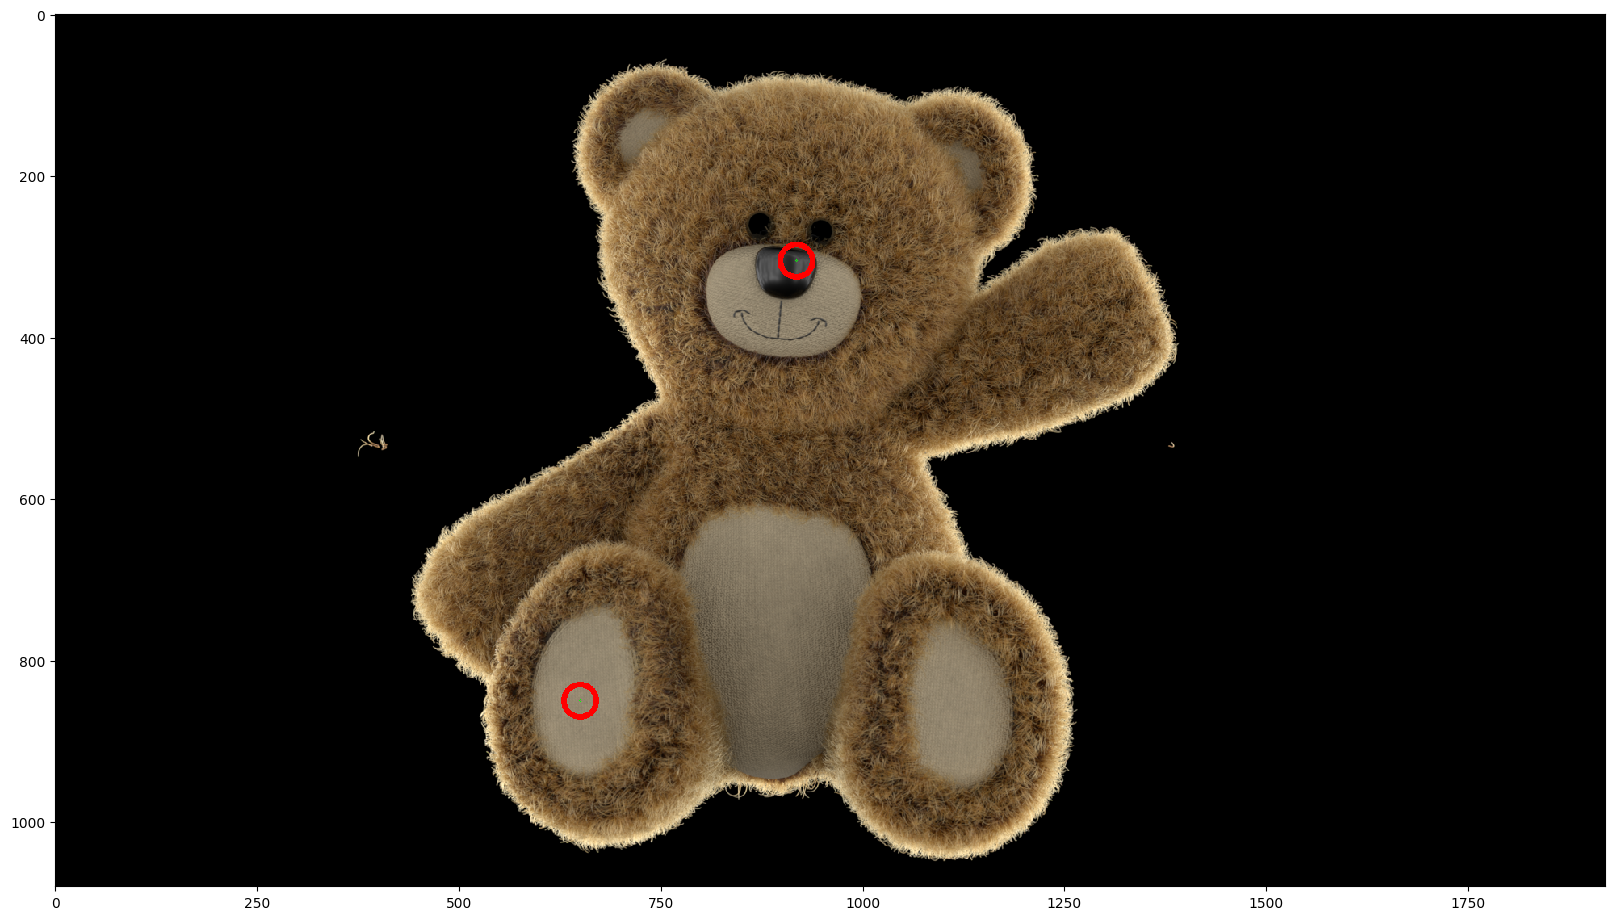

In [3]:
# Define Pixel coordinate (y, x) to plot data for
PIXEL_COORDS = ([918, 305], [650, 850])

# Get preview and show coordinate
img = seq.getPreview().asDomain(ImgDomain.sRGB, no_taich=True).asInt().get()
for coord in PIXEL_COORDS:
    img = cv.circle(img, coord, 20, [255,0,0], 5)
    img = cv.circle(img, coord, 1, [0,255,0], 1)

plt.figure(figsize=(20,20)) # New big figure
#plt.subplot(1,1,1) 
plt.imshow(img, interpolation='nearest')
# New figure
#fig_big = plt.figure(figsize=(10,10))
#plt.subplot(2,1,1) # nrows, ncols, plot_number
#plt.imshow(img, interpolation='nearest')
#plt.subplot(2,1,2) # nrows, ncols, plot_number
#plt.imshow(img, interpolation='nearest')

In [10]:
## Define real data Plotter

# Polar plot where top lights are in center
def plotPolarData(lp_sequence, pix, rotate_steps=0, resolution=50):
    fig = plt.figure()
    ax = fig.subplot(projection='3d')
    img_count = len(lp_sequence)

    # Create the mesh in polar coordinates and compute corresponding Z.
    x = np.zeros((0, ))
    y = np.zeros((0, ))
    z = np.ones((0, ))

    for _, img, lp in lpseq:
        ll = lp.getLL()
        lp_rot = LightPosition.FromLatLong([ll[0], ll[1]+rotate_steps*pi_by_2])
        x = np.append(x, [lp_rot.getZVecNorm()[0]])
        y = np.append(y, [lp_rot.getZVecNorm()[1]])
        z = np.append(z, [img.getPix(pix).lum().get()])

    # Convert polar (radii, angles) coords to cartesian (x, y) coords.
    #x = np.append(0, (radii*np.cos(angles)).flatten())
    #y = np.append(0, (radii*np.sin(angles)).flatten())
    
    # Normalize
    z = z / np.max(z)
        
    # Plot the surface.
    ax.plot_trisurf(x, y, z, vmin=z.min()*2, cmap=plt.cm.YlGnBu_r, antialiased=True)

    # Plot projections of the contours for each dimension.  By choosing offsets
    # that match the appropriate axes limits, the projected contours will sit on
    # the 'walls' of the graph
    ax.tricontourf(x, y, z, zdir='z', offset=-1.2, cmap=plt.cm.coolwarm)
    #ax.tricontourf(x, y, z, zdir='x', offset=-0.8, cmap=plt.cm.coolwarm)
    #ax.tricontourf(x, y, z, zdir='y', offset=0.8, cmap=plt.cm.coolwarm)

    # Set limits and add labels
    ax.set(xlim=(-0.8, 0.8), ylim=(-0.8, 0.8), zlim=(-1.2, 1.0),\
        xlabel='X', ylabel='Y', zlabel='Z')

    plt.show()
    


In [11]:
## Define RTI fitter functions

# General PTM function
def calcPtm(coord, pix, seq):
    u, v = coord
    
    # 1.0 + lat + long
    val = seq[0].getPix(pix).lum().get() +\
    seq[1].getPix(pix).lum().get() * u
    seq[2].getPix(pix).lum().get() * v

    # Higher degrees
    idx = 3
    for n in range(2, 6+1): # 6 is max degree
        if idx >= len(seq):
            break
        
        for i in range(n+1):
            val += u**(n-i) * v**i * seq[idx].getPix(pix).lum().get()
            idx += 1
    
    return val

# Spherical Harmonics
def calcShm(coord, pix, seq):
    return 0.0


## Define RTI Plotter

# Polar plot where top lights are in center
def plotPolarRti(fn, rotate_steps=0, resolution=50):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    # Create the mesh in polar coordinates and compute corresponding Z.
    range_lat = np.linspace(-1.0, 1.0, resolution) # Normalized -np.pi/2, np.pi/2
    range_long = np.linspace(-1.0, 1.0, resolution) # Normalized -np.pi, np.pi
    LAT, LONG = np.meshgrid(range_lat, range_long) # First is radius and repeats, second is same in whole array
    Z = np.empty((0, ))

    for lat, long in zip(LAT, LONG):
        if Z.shape == (0,):
            Z = np.array([fn(ll) for ll in zip(lat, long)]) 
        else:
            Z = np.vstack((Z, np.array([fn(ll) for ll in zip(lat, long)])))

    # Normalize
    Z = np.clip(Z / np.max(Z), 0, None) # Clamp for 0 or -1?
        
    # Express the mesh in the cartesian system.
    X, Y = (LAT+1)/2*np.sin(LONG*np.pi + rotate_steps*pi_by_2), -(LAT+1)/2*np.cos(LONG*np.pi + rotate_steps*pi_by_2)

    # Plot the surface.
    ax.plot_surface(X, Y, Z, cmap=plt.cm.YlGnBu_r, antialiased=True)
    
    # Plot projections of the contours for each dimension.  By choosing offsets
    # that match the appropriate axes limits, the projected contours will sit on
    # the 'walls' of the graph
    ax.contourf(X, Y, Z, zdir='z', offset=-1, cmap='coolwarm')
    #ax.contourf(X, Y, Z, zdir='x', offset=-1.2, cmap='coolwarm')
    #ax.contourf(X, Y, Z, zdir='y', offset=1.2, cmap='coolwarm')

    # Set limits and add labels
    ax.set(xlim=(-1.2, 1.2), ylim=(-1.2, 1.2), zlim=(-1.0, 1.0),\
        xlabel='X', ylabel='Y', zlabel='Z')

    plt.show()


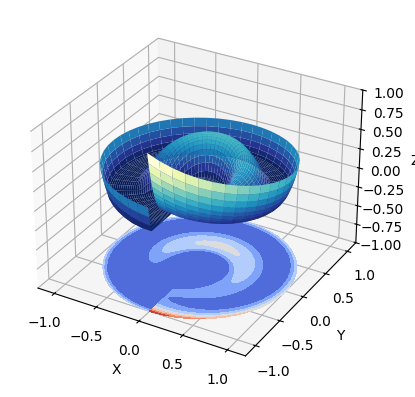

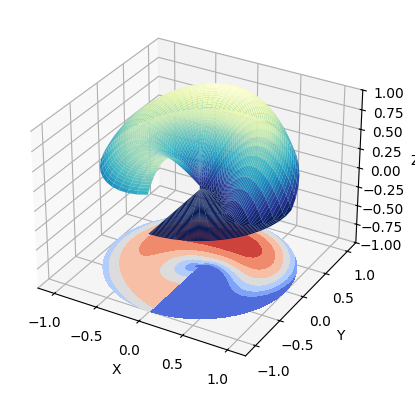

In [14]:
# Get data sequence and plot
ptm = seq.getDataSequence('ptm')

#fig_big = plt.figure(figsize=(5,5))
#plt.subplot(2,1,1) # nrows, ncols, plot_number
plotPolarRti(lambda coord: calcPtm(coord, PIXEL_COORDS[0], ptm), rotate_steps=2)
#plt.subplot(2,1,2) # nrows, ncols, plot_number
plotPolarRti(lambda coord: calcPtm(coord, PIXEL_COORDS[1], ptm), rotate_steps=2)


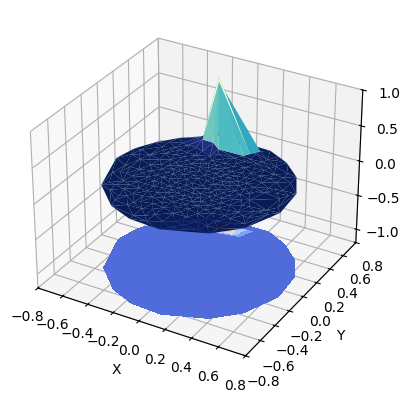

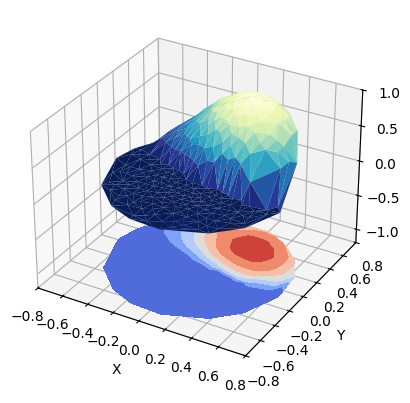

In [17]:
# Get real data and plot
#plt.figure(figsize=(10,10))
plotPolarData(lpseq, PIXEL_COORDS[0], rotate_steps=2)
plotPolarData(lpseq, PIXEL_COORDS[1], rotate_steps=2)